I am using a polytropic equation of state, which is defined as

$$ P(\varepsilon) = \Kappa\varepsilon^\gamma  $$

Since I'm using scaled units, the equation actually is written in the form

$$ P' = K'\varepsilon'^{\gamma'} $$

In [2]:
from math import log10

import numpy as np

def gamma(point_1: tuple[float, float], point_2: tuple[float, float]) -> float: 
    '''
    Calculates gamma given two points in the form (energy density, pressure).
    '''
    e_1, p_1 = point_1
    e_2, p_2 = point_2
    return log10(p_2 / p_1) / log10(e_2 / e_1)

def kappa(point_1: tuple[float, float], gamma: float) -> float:
    '''
    Calculates kappa given the pressure and energy density. Since these are estimations, 
    takes the average of the two resulting kappa values to reduce error. 
    '''
    epsilon, p = point_1
    k = p / (epsilon ** gamma)
    return k

# Constants
epsilon_1 = 10**2
epsilon_2 = 1.8 * (10**2)
# Upper Bound
ub_1 = (epsilon_1, 1)
ub_2 = (epsilon_2, 3.5)
gamma_ub = gamma(ub_1, ub_2)
kappa_ub = kappa(ub_1, gamma_ub)
print(f"Upper Bound Gamma: {gamma_ub}")
print(f"Upper Bound Kappa: {kappa_ub}")
print("----------------------------------------")

# Midline
m_1 = (epsilon_1, 0.6)
m_2 = (epsilon_2, 2.8)
gamma_m = gamma(m_1, m_2)
kappa_m = kappa(m_1, gamma_m)
print(f"Midline Gamma: {gamma_m}")
print(f"Midline Kappa: {kappa_m}")
print("----------------------------------------")


# Lower Bound
lb_1 = (epsilon_1, 0.2)
lb_2 = (epsilon_2, 2)
gamma_lb = gamma(lb_1, lb_2)
kappa_lb = kappa(lb_1, gamma_lb)
print(f"Lower Bound Gamma: {gamma_lb}")
print(f"Lower Bound Kappa: {kappa_lb}")
print("----------------------------------------")

# Averages
gamma_avg = np.average([gamma_ub, gamma_m, gamma_lb]) 
kappa_avg = np.average([kappa_ub, kappa_m, kappa_lb])
print(f"Average Gamma: {gamma_avg}")
print(f"Average Kappa: {kappa_avg}")

Upper Bound Gamma: 2.131322541493833
Upper Bound Kappa: 5.4620405123884e-05
----------------------------------------
Midline Gamma: 2.620755340211182
Midline Kappa: 3.4406505837560543e-06
----------------------------------------
Lower Bound Gamma: 3.9173823267621817
Lower Bound Kappa: 2.925939501457162e-09
----------------------------------------
Average Gamma: 2.8898200694890654
Average Kappa: 1.935466054904717e-05


These are the TOV equations.

$$
\frac{dm_r}{dr} = 4\pi r^2 \varepsilon(r)
$$

$$
\frac{dP}{dr}=
    -G\frac{m_r(r)\varepsilon(r)}{r^2}
    \left(1+\frac{P(r)}{\varepsilon(r)}\right)
    \left(1+\frac{4\pi r^3 P(r)}{m_r(r)}\right)
    \left(1-\frac{2 Gm_r(r)}{r}\right)^{-1}
$$

$r$ = radius (km).

$m_r(r)$ = the radius enclosed within a radius $r$ in ($M_\odot$).

$P(r)$ = the pressure at radius $r$ (_MeV/fm<sup>3</sup>_).

$\varepsilon(r)$ = energy density at radius $r$ (_MeV/fm<sup>3</sup>_).

$G$ = gravitational constant.



I'm going to start by using the dimensionless TOV equations.

$$
\frac{dP'}{dr'}=
    \left(-\frac{m_r' e'}{r'^2} \right)
    \left(1 + \frac{P'}{\varepsilon} \right)
    \left(1 + \frac{4\pi r'^3 P'}{m_r'} \right)
    \left(1 - \frac{2m_r'}{r'} \right)^{-1}
$$

Where a quantity being primed denotes that it is a unitless value being scaled by a constant with the units of energy density (denoted $\varepsilon_0$).

In [ ]:
import numpy as np
from scipy.constants import pi, G
from scipy.integrate import solve_ivp

# Scaling constant
E_0 = ...

def energy_density(p):
    '''
    Calculates the energy density as a function of pressure using estimated midline values for kappa and gamma.
    '''
    K = kappa_m
    gamma = gamma_m
    return (p / K) ** (1 / gamma)

def scaled_tov_rhs(r, state):
    '''
    Returns [dP/dr, dm/dr] using a TOV equation scaled by an energy density constant.
    '''
    # Pressure, mass, and density at the current radius
    p_r, m_r = state
    e_r = energy_density(p_r)
    # Mass 
    dm_dr = 4*pi * r**2 * e_r
    # Pressure (split into factors)
    f1 = -(m_r * e_r) / (r ** 2)
    f2 = 1 + (p_r / e_r)
    f3 = 1 + ((4*pi * (r**3) * p_r) / m_r)
    f4 = (1 - (2 * m_r / r)) ** -1
    dp_dr = f1 * f2 * f3 * f4
    return [dp_dr, dm_dr]

def pressure_boundary_event(r, state):
    '''
    Event for solve_ivp() that returns 0 when the pressure is 0,
    indicating that the edge fo the star has been reached.
    '''
    p, _ = state
    return p

# Cancel solve_ivp() when radius reaches boundary.
pressure_boundary_event.terminal = True

@np.vectorize
def scale_mass(m_prime):
    return m_prime / (G**3 * E_0)

@np.vectorize
def scale_radius(r): ...

# TODO: Find valid values for these
# The interval on which to evaluate solve_ivp()
R_START = 0.01 # km. Has to be greater than zero.
R_END = 20 # km
# r_points = np.linspace(R_START, R_END, num=20)
# Central pressure.
P_C = 100 # MeV/fm^3
# Central enclosed mass.
M_0 = 0.1 # Solar Masses

def solve():
    solutions = solve_ivp(
        scaled_tov_rhs,
        t_span=(R_START, R_END),
        y0=(P_C, M_0),
        events=pressure_boundary_event
    )
    scale_radius(solutions.t)
    scale_mass(solutions.y[1])
    return solutions

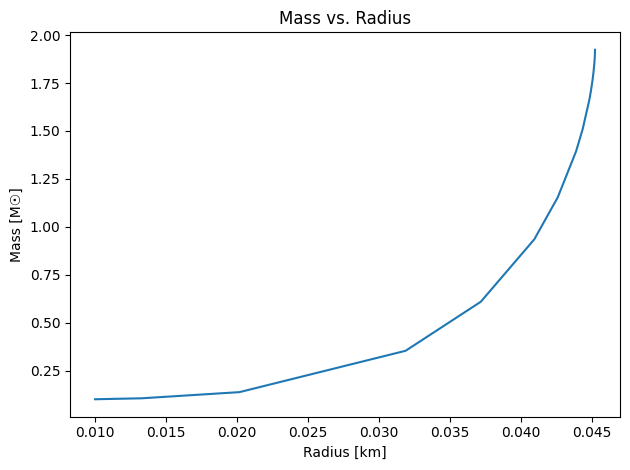

In [4]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

# The graphs here aren't useful because they aren't using realistic values.

solutions = solve()
r_solutions = solutions.t
m_solutions = solutions.y[1]

subplots: tuple[Figure, Axes] = plt.subplots()
fig, ax = subplots

ax.set_title("Mass vs. Radius")
ax.set_ylabel("Mass [M☉]")
ax.set_xlabel("Radius [km]")
ax.plot(r_solutions, m_solutions)

fig.tight_layout()
plt.show()